***Create first Simple model***\
Author- Gautam Gogoi\
Date - 17th Nov \
Objective- Create first tree based model and understand results

In [16]:
import pandas as pd 
import numpy as np 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score


In [17]:
# The following 3 functions have been taken from Ben Hamner's github repository
# https://github.com/benhamner/Metrics
def Cmatrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = Cmatrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

In [50]:
df = pd.read_pickle('df_featureEngg_v1')
df.info()
df['PCIAT-PCIAT_Total'].describe()
df_sii = df[df['sii']>=0]
print (df_sii.sii.value_counts()) 
print (df_sii.test_train_flag.value_counts())
df_sii['weights'] = np.where(df_sii['sii']==3,5,1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 99 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2420 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898 non-null    floa

C:\Users\gogoig\AppData\Local\Temp\ipykernel_15520\2415707339.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sii['weights'] = np.where(df_sii['sii']==3,2,1)


In [51]:
season_cols = [col for col in df_sii.columns if 'Season' in col]
df_sii = df_sii.drop(season_cols, axis=1) 
df_sii.columns

train_labels_sii=df_sii[df_sii['test_train_flag']=='Train']['sii']
test_labels_sii=df_sii[df_sii['test_train_flag']=='Test']['sii']

train_labels_pciat=df_sii[df_sii['test_train_flag']=='Train']['PCIAT-PCIAT_Total']
test_labels_pciat=df_sii[df_sii['test_train_flag']=='Test']['PCIAT-PCIAT_Total']

train_weights=df_sii[df_sii['test_train_flag']=='Train']['weights']
test_weights=df_sii[df_sii['test_train_flag']=='Test']['weights']

pciat_cols = [col for col in df_sii.columns if 'PCIAT-PCIAT' in col]
df_sii = df_sii.drop(pciat_cols, axis=1) 
df_sii = df_sii.drop(['sii', 'id'], axis=1)
df_sii.columns

Index(['Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI',
       'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
       'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins',
       'Fitness_Endurance-Time_Sec', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone',
       'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone',
       'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone',
       'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
       'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
       'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
       'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
       'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total',
       'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T',
       'Pre

In [52]:
print(train_labels_sii.describe())
print(test_labels_sii.describe())

print(train_labels_pciat.describe())
print(test_labels_pciat.describe())

count    2173.000000
mean        0.585366
std         0.777034
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         3.000000
Name: sii, dtype: float64
count    563.000000
mean       0.561279
std        0.748231
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        3.000000
Name: sii, dtype: float64
count    2173.000000
mean       28.104464
std        20.501418
min         0.000000
25%        12.000000
50%        27.000000
75%        41.000000
max        92.000000
Name: PCIAT-PCIAT_Total, dtype: float64
count    563.000000
mean      27.092362
std       19.695963
min        0.000000
25%       11.000000
50%       26.000000
75%       40.000000
max       93.000000
Name: PCIAT-PCIAT_Total, dtype: float64


In [53]:
train_features=df_sii[df_sii['test_train_flag']=='Train']
test_features=df_sii[df_sii['test_train_flag']=='Test']

train_features = train_features.drop(['test_train_flag', 'weights'], axis=1)
test_features = test_features.drop(['test_train_flag', 'weights'], axis=1)


In [54]:
print (test_features.info())
print (train_features.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 563 entries, 0 to 3955
Data columns (total 64 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Basic_Demos-Age                         563 non-null    int64  
 1   Basic_Demos-Sex                         563 non-null    int64  
 2   CGAS-CGAS_Score                         478 non-null    float64
 3   Physical-BMI                            517 non-null    float64
 4   Physical-Height                         518 non-null    float64
 5   Physical-Weight                         525 non-null    float64
 6   Physical-Waist_Circumference            106 non-null    float64
 7   Physical-Diastolic_BP                   506 non-null    float64
 8   Physical-HeartRate                      507 non-null    float64
 9   Physical-Systolic_BP                    506 non-null    float64
 10  Fitness_Endurance-Max_Stage             147 non-null    float

0.4355161464262177

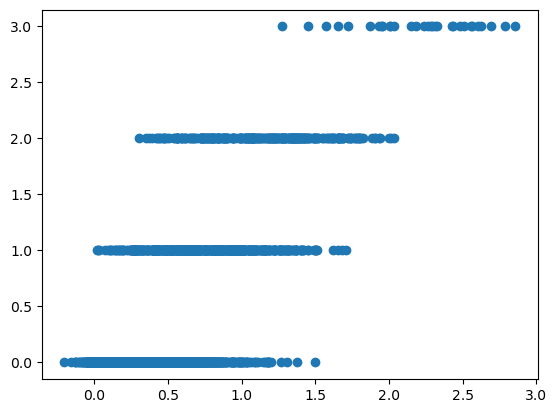

In [55]:
from sklearn.ensemble import HistGradientBoostingRegressor
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

pipe = Pipeline([
    ("model", HistGradientBoostingRegressor(max_iter=80, max_depth=3))
])

model = GridSearchCV(estimator=pipe,
                 param_grid={
                   'model__max_iter': [10,  30, 50, 70, 90, 110, 130, 150, 200], 
                   'model__max_depth': [1,  3, 5, 7, 9, 11, 13, 15, 20]  
                 },
                 scoring={'kappa': make_scorer(quadratic_weighted_kappa)},
                 refit='kappa',    
                 cv=3)

fit_params= {'model__sample_weight':train_weights}
model.fit(train_features, train_labels_sii, **fit_params);


pred= model.predict(train_features)
plt.scatter(pred, train_labels)
quadratic_weighted_kappa(train_labels_sii, pred)

0.21012862387550768

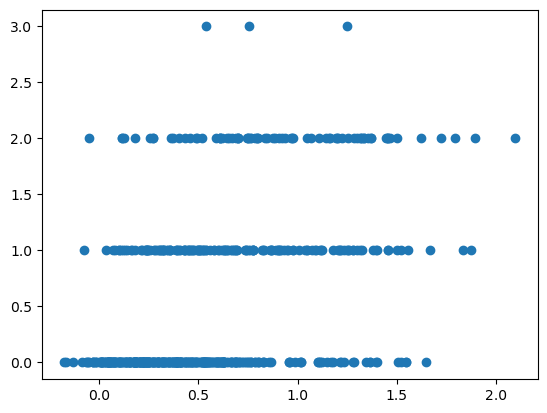

In [56]:
pred_test= model.predict(test_features)
plt.scatter(pred_test, test_labels_sii)
quadratic_weighted_kappa(test_labels_sii, pred_test)

In [39]:
pd.set_option('display.max_rows', 100)
pd.DataFrame(model.cv_results_)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__max_iter,params,split0_test_kappa,split1_test_kappa,split2_test_kappa,mean_test_kappa,std_test_kappa,rank_test_kappa
0,0.030188,0.001139,0.003225,2.573097e-04,1,10,"{'model__max_depth': 1, 'model__max_iter': 10}",0.147468,0.195883,0.176993,0.173448,0.019924,81
1,0.044130,0.001248,0.003200,2.821029e-04,1,30,"{'model__max_depth': 1, 'model__max_iter': 30}",0.216512,0.235209,0.260282,0.237334,0.017932,37
2,0.055046,0.001921,0.003792,2.412975e-04,1,50,"{'model__max_depth': 1, 'model__max_iter': 50}",0.257041,0.259309,0.285632,0.267327,0.012976,7
3,0.066427,0.000762,0.004046,3.748879e-05,1,70,"{'model__max_depth': 1, 'model__max_iter': 70}",0.252531,0.265606,0.289567,0.269235,0.015336,6
4,0.076757,0.000985,0.004404,2.231071e-04,1,90,"{'model__max_depth': 1, 'model__max_iter': 90}",0.259583,0.265620,0.291289,0.272164,0.013746,4
5,0.088320,0.001452,0.004961,5.692643e-05,1,110,"{'model__max_depth': 1, 'model__max_iter': 110}",0.257041,0.286122,0.296459,0.279874,0.016688,1
6,0.103336,0.001292,0.005243,5.824452e-04,1,130,"{'model__max_depth': 1, 'model__max_iter': 130}",0.245941,0.281959,0.280327,0.269409,0.016608,5
7,0.116636,0.002311,0.006097,8.274020e-04,1,150,"{'model__max_depth': 1, 'model__max_iter': 150}",0.243722,0.294828,0.295697,0.278082,0.024299,2
8,0.147495,0.004056,0.053998,6.514109e-02,1,200,"{'model__max_depth': 1, 'model__max_iter': 200}",0.248553,0.289868,0.295315,0.277912,0.020878,3
9,0.046625,0.004424,0.003000,1.946680e-07,3,10,"{'model__max_depth': 3, 'model__max_iter': 10}",0.202201,0.166749,0.222633,0.197194,0.023087,73


In [40]:
import eli5
from eli5.sklearn import PermutationImportance

# Calculate the feature importance
importances = PermutationImportance(model).fit(train_features, train_labels)

# Print the feature importance
eli5.show_weights(importances)

Weight,Feature
0.1065 ± 0.0117,x49
0.0501 ± 0.0151,x0
0.0334 ± 0.0105,x45
0.0269 ± 0.0097,x48
0.0226 ± 0.0080,x47
0.0225 ± 0.0112,x13
0.0224 ± 0.0064,x46
0.0134 ± 0.0041,x59
0.0129 ± 0.0050,x5
0.0113 ± 0.0086,x1


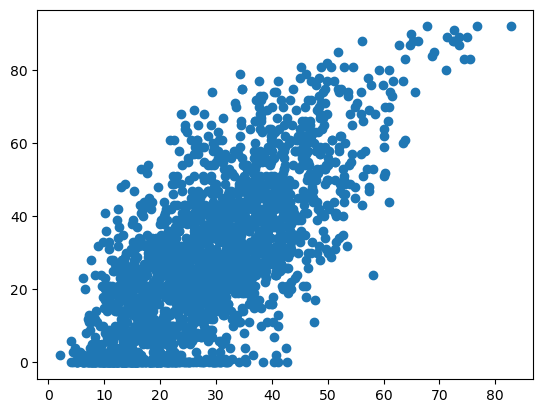

In [66]:
from sklearn.ensemble import HistGradientBoostingRegressor
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

pipe = Pipeline([
    ("model", HistGradientBoostingRegressor(max_iter=80, max_depth=3))
])

model = GridSearchCV(estimator=pipe,
                 param_grid={
                   'model__max_iter': [10,  30, 50, 70, 90, 110, 130, 150, 200], 
                   'model__max_depth': [1,  3, 5, 7, 9, 11, 13, 15, 20]  
                 },
                 scoring={'kappa': make_scorer(quadratic_weighted_kappa)},
                 refit='kappa',    
                 cv=3)

fit_params= {'model__sample_weight':train_weights}
model.fit(train_features, train_labels_pciat, **fit_params);


pred= model.predict(train_features)
plt.scatter(pred, train_labels_pciat)

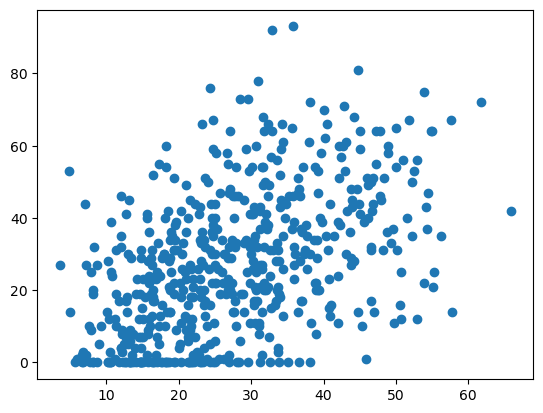

In [67]:
pred_test= model.predict(test_features)
plt.scatter(pred_test, test_labels_pciat)

In [59]:
def get_sii_from_pciat (pred):
    condlist=[pred<=30, (pred>30)&(pred<50),(pred>=50)&(pred<80),(pred>=80) ]
    choicelist= [0,1,2,3]
    return (np.select(condlist,choicelist))


In [68]:
pred_train_sii = get_sii_from_pciat(pred)
pred_test_sii = get_sii_from_pciat(pred_test)

In [69]:
print(quadratic_weighted_kappa(train_labels_sii, pred_train_sii))
print (quadratic_weighted_kappa(test_labels_sii, pred_test_sii))

0.576947991856376
0.3573678058172316


Test Kappa - 0.3647610752603032 - for model trained on pciat with weights 5 \
Test Kappa - 0.25945825437520875 - for model trained on sii with weights 5 \ - with kappa socring for cv

Test Kappa - 0.3617637836515435 - for model trained on pciat with weights 2 \ - with kappa socring for cv 3 fold
Test Kappa - 0.21012862387550768 - for model trained on sii with weights 2 \ 
Test Kappa - 0.3617637836515435 - for model trained on pciat with weights 2 \ - without kapp scoring
Test Kappa - 0.3573678058172316 - for model trained on pciat with weights 2 \ - with kappa socring for cv 3 fold
